In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install skforecast

## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, we want to predict all variables therefore therefore, we are going build a model that can handle parallel multiseries data

> Parallel multiseries forcasting can be:
 * ***Dependent*** multi-series => using *ForecasterAutoregMultiSeries* and *ForecasterAutoregMultiSeriesCustom* classes
 * ***Independent*** multiseries => using  *ForecasterAutoregMultiVariate* class

## Independent

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_downsampled = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_MODISData.csv')
df_downsampled = df_downsampled[['date','ndvi','evi','ndwi']]
df_downsampled.head()

,date,ndvi,evi,ndwi
0,2000-03-23,0.194392,0.131728,-0.066057
1,2000-03-30,0.188009,0.121651,-0.059209
2,2000-04-06,0.180129,0.124651,-0.051936
3,2000-04-13,0.167050,0.131804,-0.032578
4,2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Data preparation
data = df_downsampled
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,ndvi,evi,ndwi
date,,,
2000-03-23,0.194392,0.131728,-0.066057
2000-03-30,0.188009,0.121651,-0.059209
2000-04-06,0.180129,0.124651,-0.051936
2000-04-13,0.167050,0.131804,-0.032578
2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2000-03-23 00:00:00 --- 2019-12-26 00:00:00   (n=1032)
Test dates  : 2020-01-02 00:00:00 --- 2023-02-16 00:00:00   (n=164)


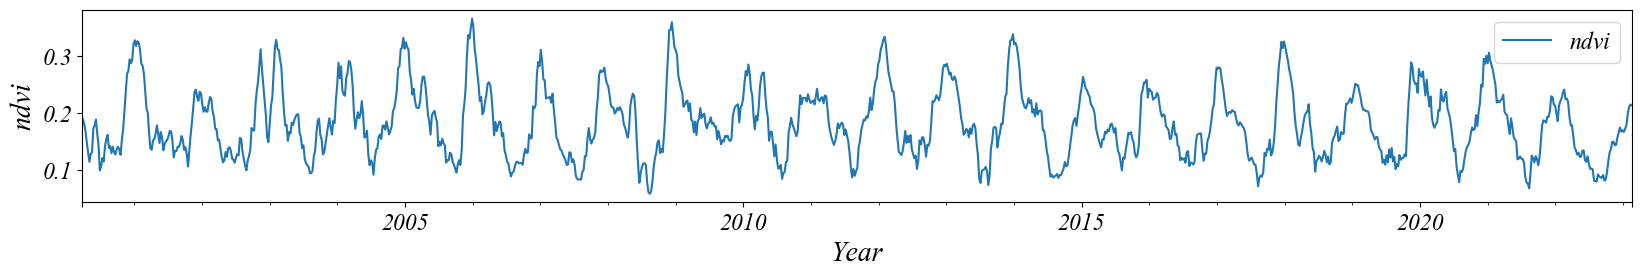

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

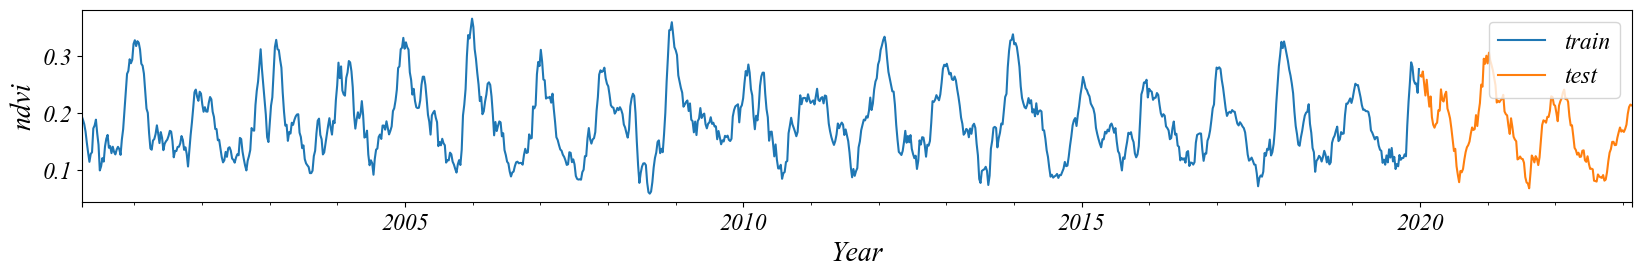

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

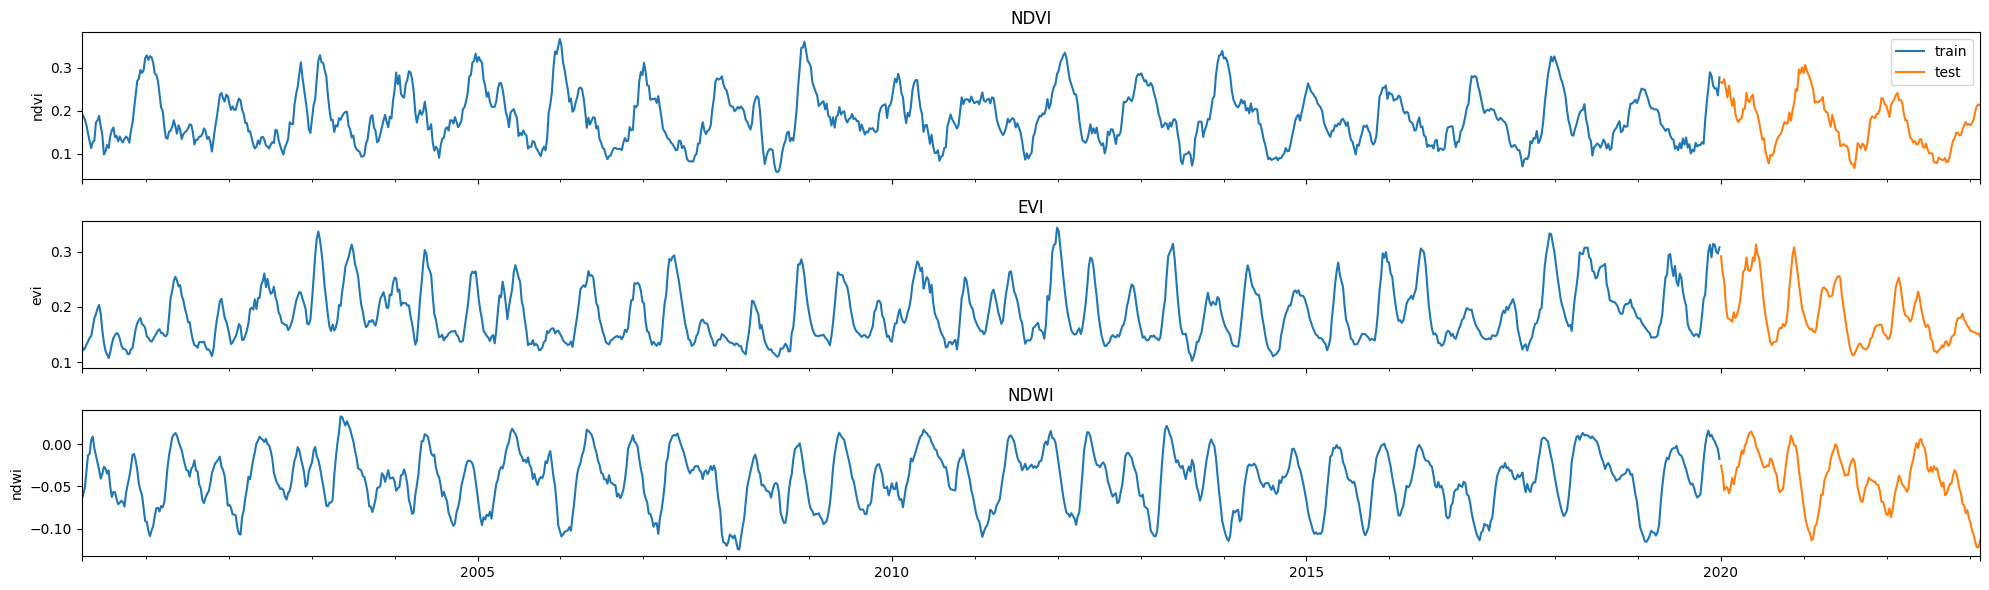

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 6), sharex=True)

data_train['ndvi'].plot(label='train', ax=axes[0])
data_test['ndvi'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('ndvi')
axes[0].set_title('NDVI')
axes[0].legend()

data_train['evi'].plot(label='train', ax=axes[1])
data_test['evi'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('evi')
axes[1].set_title('EVI')

data_train['ndwi'].plot(label='train', ax=axes[2])
data_test['ndwi'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('ndwi')
axes[2].set_title('NDWI')

fig.tight_layout()
plt.show();

### RF

> Single-Step

In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(),
                 lags               = 5,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [10, 20, 50, 100, 200]
param_distributions = {
    'n_estimators': np.arange(start=10, stop=20, step=1, dtype=int),
    'max_depth': np.arange(start=5, stop=15, step=1, dtype=int)
}
levels = ['ndvi', 'evi', 'ndwi']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_distributions,
              steps               = 1,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

500 models compared for 3 level(s). Number of iterations: 500.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/100 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,max_depth,n_estimators
224,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 14}",0.008542,7,14
21,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 11}",0.008579,7,11
235,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 15}",0.008598,8,15
238,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 18}",0.008599,8,18
29,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 19}",0.008601,7,19
...,...,...,...,...,...,...
381,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'n_estimators': 11}",0.009665,13,11
363,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 11, 'n_estimators': 13}",0.009690,11,13
481,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'n_estimators': 11}",0.009693,13,11
370,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 12, 'n_estimators': 10}",0.009759,12,10


In [ ]:
print(results.lags[297],results.params[297])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] {'max_depth': 14, 'n_estimators': 17}


In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(max_depth= 14, n_estimators=17),
                 lags               = 50,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )
forecaster.fit(data_train)

In [ ]:
# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = None,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/164 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,ndvi,0.011526,0.000223,0.073762
1,evi,0.008854,0.000129,0.046919
2,ndwi,0.005500,0.000045,0.483235



Backtest predictions


,ndvi,evi,ndwi
2020-01-02,0.274922,0.300572,-0.029524
2020-01-09,0.265549,0.294367,-0.037499
2020-01-16,0.257694,0.247765,-0.048166
2020-01-23,0.264835,0.226263,-0.064705


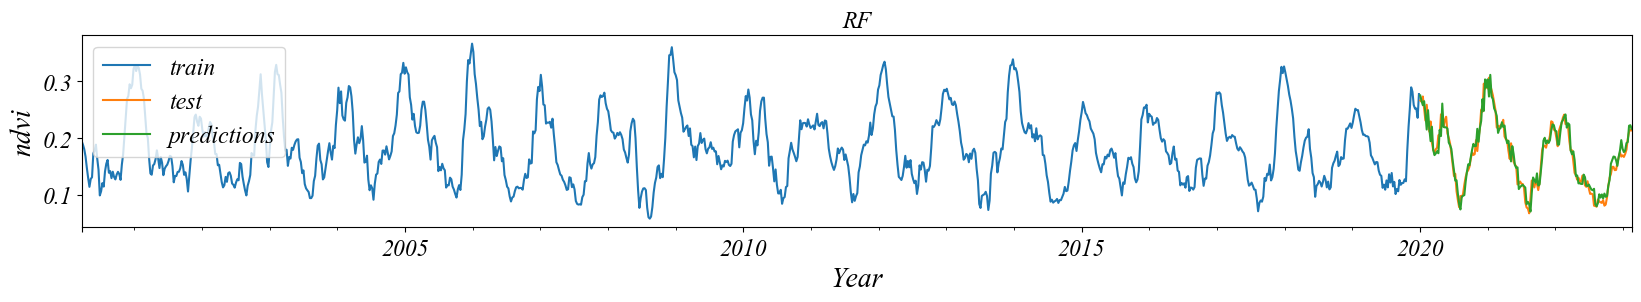

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='RF')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

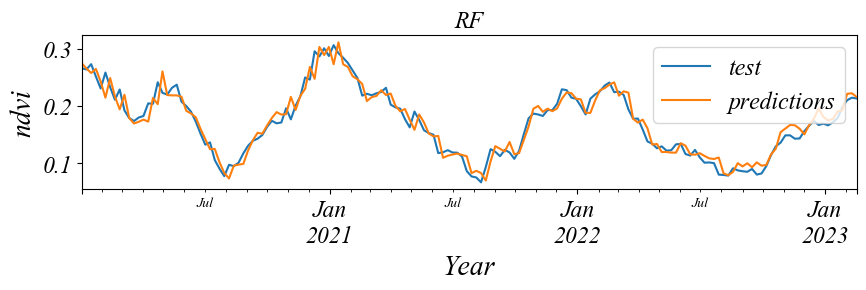

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='RF')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

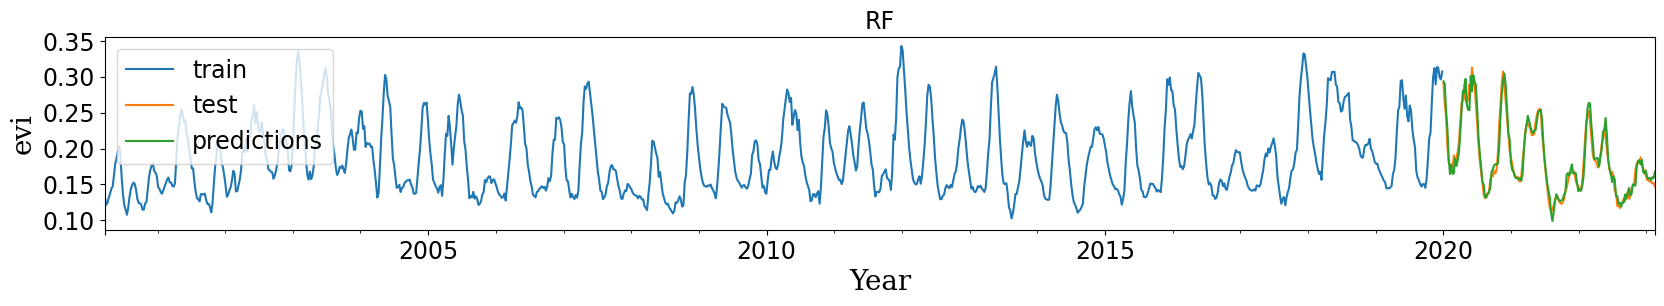

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['evi'].plot(ax=ax, label='train')
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='RF')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

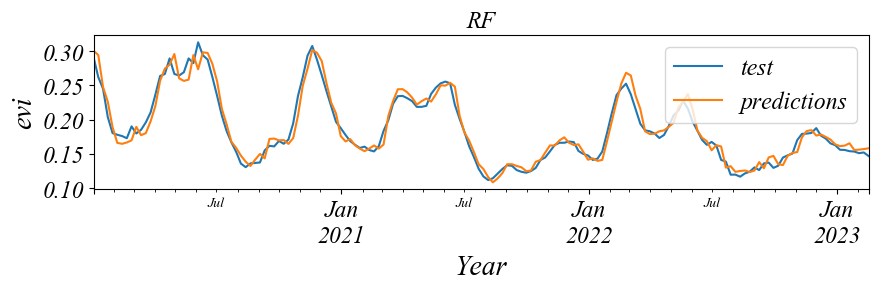

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='RF')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

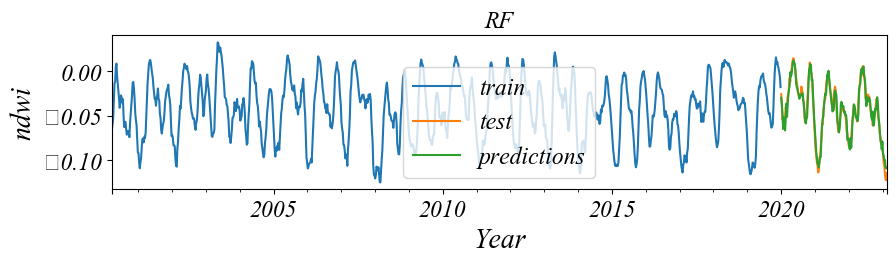

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_train['ndwi'].plot(ax=ax, label='train')
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='RF')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

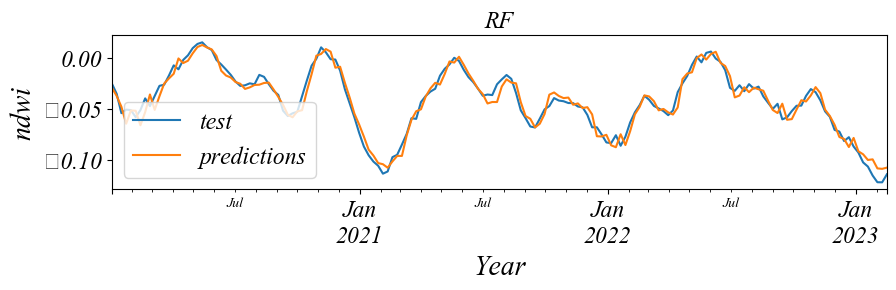

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='RF')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndvi'],backtest_predictions['ndvi'])
mse = mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi'])
r2 = r2_score(data_test['ndvi'],backtest_predictions['ndvi'])
rmse = math.sqrt(mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.012195929359815245
MSE is 0.0002313859399845487
RMSE is 0.015211375348223732
R2 is 0.9300998887030381


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['evi'],backtest_predictions['evi'])
mse = mean_squared_error(data_test['evi'],backtest_predictions['evi'])
r2 = r2_score(data_test['evi'],backtest_predictions['evi'])
rmse = math.sqrt(mean_squared_error(data_test['evi'],backtest_predictions['evi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.008711798812921289
MSE is 0.00013811191448448576
RMSE is 0.011752102555904018
R2 is 0.9420185348318233


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndwi'],backtest_predictions['ndwi'])
mse = mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi'])
r2 = r2_score(data_test['ndwi'],backtest_predictions['ndwi'])
rmse = math.sqrt(mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.005644452116057318
MSE is 4.6782524577606634e-05
RMSE is 0.0068397751847269535
R2 is 0.9508051146749963


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.008850726762931284
MSE is 0.00013876012634888037
RMSE is 0.011779648821118581
R2 is 0.9409745127366191


In [ ]:
forecaster.fit(data)

In [ ]:
future_prediction=forecaster.predict(steps=300)

In [ ]:
future_prediction.head()

,ndvi,evi,ndwi
2023-02-23,0.204302,0.147570,-0.109507
2023-03-02,0.199724,0.147221,-0.103449
2023-03-09,0.190364,0.148206,-0.098515
2023-03-16,0.180633,0.148182,-0.094843
2023-03-23,0.167666,0.147033,-0.089081


Text(0, 0.5, 'NDVI')

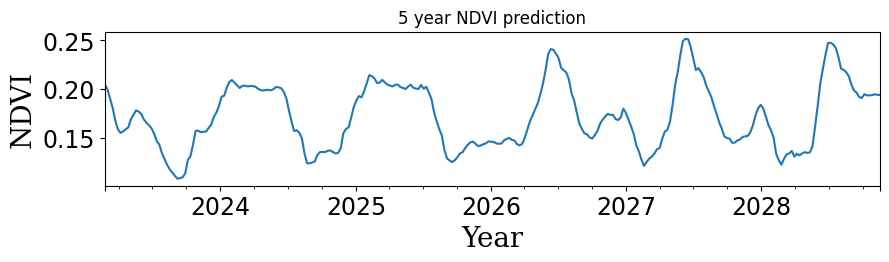

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['ndvi'].plot(ax=ax, label='ndvi',title='5 year NDVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)

Text(0, 0.5, 'EVI')

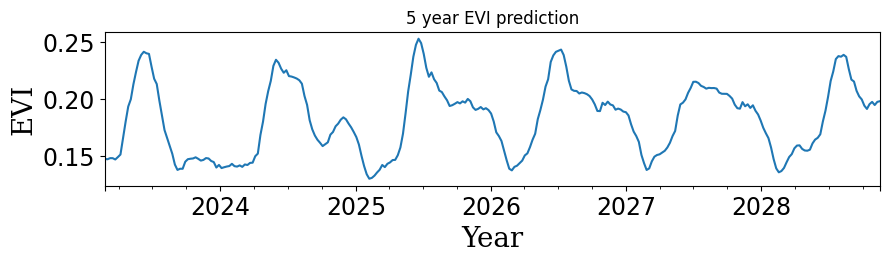

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['evi'].plot(ax=ax, label='evi',title='5 year EVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("EVI",fontdict = font2)

Text(0, 0.5, 'NDWI')

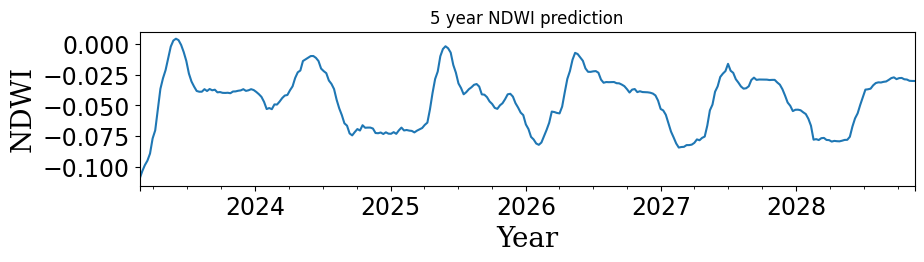

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['ndwi'].plot(ax=ax, label='ndwi',title='5 year NDWI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)